<a href="https://colab.research.google.com/github/Osterne/codes_DS_course/blob/main/05_mod_ap_n_sup_01_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

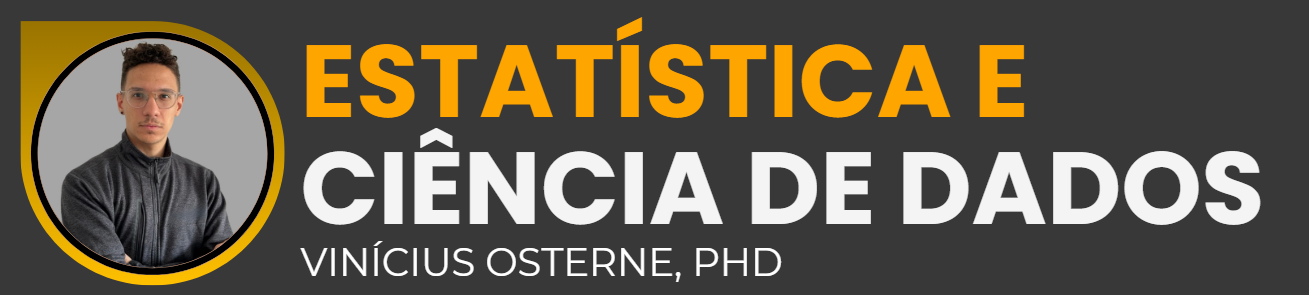

---

# Aprendizado Não Supervisionado - Métodos de Clustering (Agrupamento)

### K-means

---
<br><br><br><br><br>

# Introdução

- O **K-means** é um algoritmo de **aprendizado não supervisionado**, pertencente à categoria de **agrupamento (clustering)**.  
- Seu objetivo é **particionar observações em K grupos (clusters)**, de modo que os pontos dentro de um mesmo cluster sejam mais semelhantes entre si do que em relação a pontos de outros clusters.  
- Para isso, o algoritmo busca **centroides (médias)** que representem cada grupo, minimizando a soma das distâncias quadráticas entre os pontos e seus respectivos centroides.  
- Na prática, o K-means procura formar clusters com **alta coesão interna (baixa variabilidade intra-cluster)** e **boa separação entre grupos (alta variabilidade inter-cluster)**.  


### Quando usar
- Descobrir **padrões ou grupos naturais** em dados numéricos sem rótulos.  
- **Segmentação de clientes** em marketing, com base em hábitos de consumo.  
- **Compressão de dados** (ex.: reduzir cores em uma imagem agrupando pixels).  
- **Inicialização de outros métodos** (ex.: mistura de gaussianas ou algoritmos de classificação).  

### Condições implícitas
- Os grupos tendem a ser **esféricos e de tamanho semelhante**.  
- As **variáveis precisam estar na mesma escala** (normalização/padronização é essencial).  
- O algoritmo é **sensível a outliers**, que podem distorcer os centroides.  
- Também é **sensível à escolha de K** (número de clusters).  

> ⚠️ **Atenção**: K-means não é indicado para dados categóricos, clusters de formas arbitrárias ou tamanhos muito diferentes.


<br><br><br>


# Estrutura do Modelo

### Objetivo de Otimização

O K-means procura resolver o seguinte problema de minimização:

$$
\min_{\{C_k\}, \{\mu_k\}} \sum_{k=1}^{K} \sum_{x_i \in C_k} \| x_i - \mu_k \|^2
$$

- $C_k$: conjunto de pontos no cluster $k$  
- $\mu_k$: centroide do cluster $k$  
- $\| x_i - \mu_k \|^2$: distância euclidiana quadrática entre um ponto $x_i$ e o centroide do cluster.  

Em outras palavras: o objetivo é encontrar a partição que **minimiza a soma das distâncias quadradas intra-cluster**.


<br><br><br>


# Algoritmo de Lloyd (passo a passo)

O método mais usado para implementar o K-means é o **algoritmo de Lloyd**:

1. **Inicializar** $K$ centroides aleatórios (ou usando métodos mais estáveis, como **K-means++**).  
2. **Atribuir** cada ponto ao centroide mais próximo, formando clusters provisórios.  
3. **Atualizar** cada centroide como a média dos pontos que lhe foram atribuídos.  
4. **Repetir** os passos 2 e 3 até convergir (quando não houver mudança significativa nos centroides ou atingir número máximo de iterações).

> 🔄 O algoritmo pode convergir para **mínimos locais**, por isso recomenda-se rodar o K-means várias vezes com inicializações diferentes e escolher a solução com menor custo.


<br><br><br>


# Escolha de \(K\)

- A escolha do número de clusters ($K$) é um dos pontos mais críticos.  

- Não existe uma resposta única, mas alguns métodos práticos incluem:

- **1. Elbow Method (WSS)**  
  - Analisa a curva da **soma dos quadrados intra-cluster (WSS)** em função de $K$.  
  - Procura-se o “cotovelo” da curva, onde o ganho de explicação de variância começa a diminuir.

- **2. Silhouette**  
  - Mede quão **coeso** é cada cluster e quão **bem separado** ele está dos demais.  
  - O índice varia de -1 a 1, sendo valores próximos de 1 indicativos de melhor separação.

- **3. Gap Statistic**  
  - Compara a dispersão intra-cluster obtida com a de uma **distribuição de referência (aleatória)**.  
  - Um valor alto de gap indica que a estrutura de clusters é mais forte que o esperado ao acaso.

> 📌 Em aplicações reais, muitas vezes a escolha de $K$ também depende de **conhecimento do domínio** e da **interpretação prática dos grupos**.


<br><br><br>


# Aplicação
- Vamos ilustrar o algoritmo apresentado utilizando uma aplicação em dados reais



In [10]:
# ## 1) Setup
# - Importar libs
# - Carregar dataset real (palmerpenguins)

# %%
!pip -q install seaborn scikit-learn

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [11]:
# ## 2) Carregar e explorar os dados
# O dataset já vem no seaborn: `penguins`
# Variáveis:
# - species: espécie do pinguim (Adelie, Chinstrap, Gentoo)
# - island: ilha onde foi observado (Torgersen, Biscoe, Dream)
# - bill_length_mm: comprimento do bico (mm)
# - bill_depth_mm: profundidade/altura do bico (mm)
# - flipper_length_mm: comprimento da nadadeira (mm)
# - body_mass_g: massa corporal (g)
# - sex: sexo (male/female)

# %%
penguins = sns.load_dataset("penguins")
print(penguins.shape)
penguins.head()


(344, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [12]:
# ## 3) Selecionar variáveis numéricas e tratar NA
# Vamos trabalhar apenas com medidas contínuas.

# %%
features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
df = penguins[features].dropna()
df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


In [13]:
# ## 4) Padronização
# Distâncias euclidianas são sensíveis à escala ⇒ padronizar é essencial.

from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd

# StandardScaler → centraliza média em 0 e desvio padrão em 1
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(df)

# RobustScaler → usa mediana e IQR (mais robusto a outliers)
scaler_rob = RobustScaler()
X_rob = scaler_rob.fit_transform(df)

# Converte para DataFrame para inspecionar
df_std = pd.DataFrame(X_std, columns=df.columns)
df_rob = pd.DataFrame(X_rob, columns=df.columns)

print("=== Primeiras linhas com StandardScaler ===")
print(df_std.head(), "\n")

print("=== Primeiras linhas com RobustScaler ===")
print(df_rob.head())


=== Primeiras linhas com StandardScaler ===
   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0       -0.884499       0.785449          -1.418347    -0.564142
1       -0.811126       0.126188          -1.062250    -0.501703
2       -0.664380       0.430462          -0.421277    -1.188532
3       -1.324737       1.089724          -0.563715    -0.938776
4       -0.847812       1.748985          -0.777373    -0.689020 

=== Primeiras linhas com RobustScaler ===
   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0       -0.576819       0.451613          -0.695652    -0.250000
1       -0.533693       0.032258          -0.478261    -0.208333
2       -0.447439       0.225806          -0.086957    -0.666667
3       -0.835580       0.645161          -0.173913    -0.500000
4       -0.555256       1.064516          -0.304348    -0.333333


In [14]:
# Vamos seguir com o StandardScaler (média=0, desvio=1)
scaler = StandardScaler()
X = scaler.fit_transform(df)

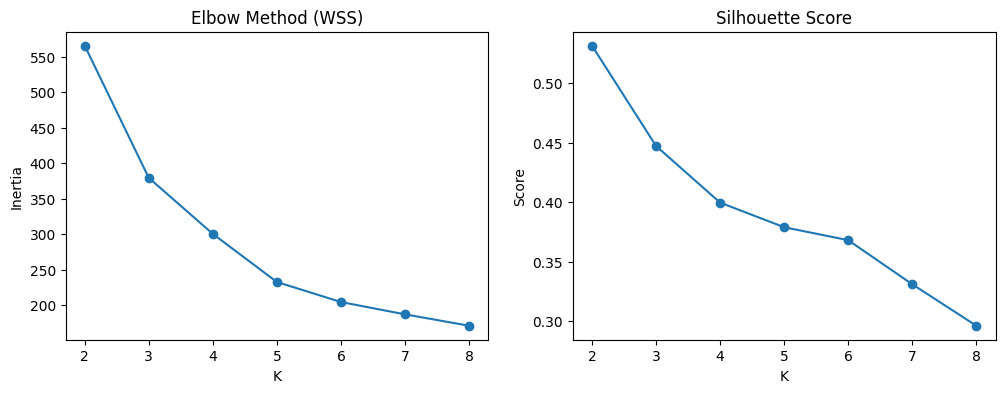

In [15]:
# ## 5) Escolha de K (Elbow + Silhouette)
# Testamos valores de K entre 2 e 8.

# %%
inertia, sil = [], []
K_range = range(2, 9)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(X, labels))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Elbow
ax[0].plot(K_range, inertia, marker="o")
ax[0].set_title("Elbow Method (WSS)") #soma das distâncias quadradas intra-cluster (WSS)
ax[0].set_xlabel("K")
ax[0].set_ylabel("Inertia")

# Silhouette
ax[1].plot(K_range, sil, marker="o")
ax[1].set_title("Silhouette Score") #mede quão coesos estão os pontos dentro de um cluster e quão bem separados estão dos outros.
ax[1].set_xlabel("K")
ax[1].set_ylabel("Score")

plt.show()

In [16]:
# ## 6) Treinar modelo com K=3
# A análise visual sugere que 3 clusters é adequado (spoiler: coincide com as espécies reais).

# %%
k = 3
kmeans = KMeans(n_clusters=k, n_init=30, random_state=42)
labels = kmeans.fit_predict(X)

df_clustered = df.copy()
df_clustered["cluster"] = labels
df_clustered.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,cluster
0,39.1,18.7,181.0,3750.0,2
1,39.5,17.4,186.0,3800.0,2
2,40.3,18.0,195.0,3250.0,2
4,36.7,19.3,193.0,3450.0,2
5,39.3,20.6,190.0,3650.0,2


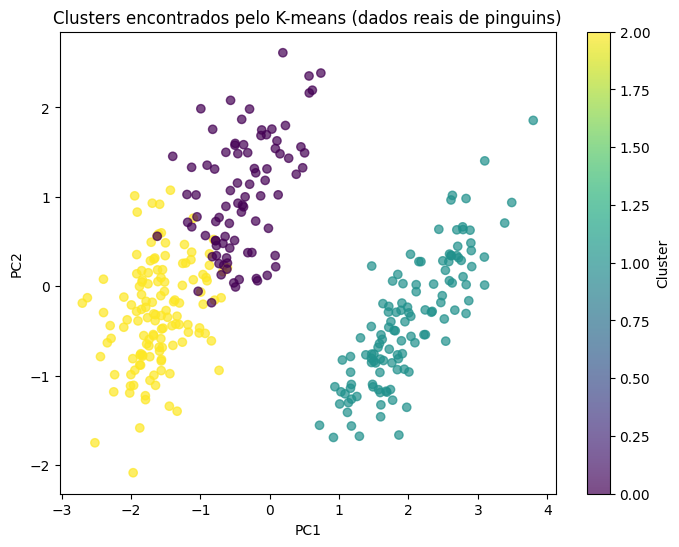

In [17]:
# ## 7) Visualização 2D via PCA
# Reduzimos para 2 dimensões e colorimos por cluster atribuído pelo K-means.

# %%
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="viridis", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters encontrados pelo K-means (dados reais de pinguins)")
plt.colorbar(label="Cluster")
plt.show()

In [18]:
# ## 8) Perfil dos clusters
# Olhando a média de cada variável em cada grupo → interpretação prática.

# %%
df_clustered.groupby("cluster").mean().round(1)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
cluster,,,,
0,47.5,18.8,196.9,3902.0
1,47.5,15.0,217.2,5076.0
2,38.2,18.1,188.4,3584.7
